In [3]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import numpy as np
import os
from datetime import datetime,timedelta
import streamlit as st

# 1 nettoyage tittle basic

In [73]:
dftb = pd.read_csv('data-set/title.basics.tsv', sep='\t')


C:\Users\A406176\AppData\Local\Temp\ipykernel_2676\1365331395.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dftb = pd.read_csv('data-set/title.basics.tsv', sep='\t')


In [74]:
for col in dftb.columns:
    if dftb[col].dtype == 'float64':
        if dftb[col].notna().all():
            dftb[col] = dftb[col].astype('int32')
        else:
            dftb[col] = dftb[col].astype('float32')

In [ ]:
# Rename columns en anglais c'est styler TILTE BASCIS
new_names = {
    'tconst': 'ID_Titre',
    'titleType': 'Categorie',
    'primaryTitle': 'Titre_Principal',
    'originalTitle': 'Titre_Original',
    'isAdult': 'Film_Adultes',
    'startYear': 'Annee_Debut',
    'endYear': 'Annee_Fin',
    'runtimeMinutes': 'Duree_Minutes',
    'genres': 'Genres'
}
dftb.rename(columns=new_names, inplace=True)
# Conversion des colonnes 'Annee_Debut' et 'Duree_Minutes' en numériques pour pouvoir aplliqu les filtre 
dftb['Annee_Debut'] = pd.to_numeric(dftb['Annee_Debut'], errors='coerce')
dftb['Duree_Minutes'] = pd.to_numeric(dftb['Duree_Minutes'], errors='coerce')

# Suppression des lignes avec des valeurs NaN 
dftb.dropna(subset=['Annee_Debut', 'Duree_Minutes'], inplace=True)
# Filtrage des films entre 2023 et 2025 avec une durée entre 120 et 300 minutes
df_title_basics_filtré = dftb[
    (dftb['Categorie'] == 'movie') &
    (dftb['Duree_Minutes'] >= 90) &       
    (dftb['Duree_Minutes'] <= 300) &
    (dftb['Annee_Debut'] >= 1980) &         
    (dftb['Annee_Debut'] <= 2024)            
]
# Suppression des doublons basée sur 'Titre_Original'
df_title_basics_filtré = df_title_basics_filtré.drop_duplicates(subset=['Titre_Original'])
# Sélection des colonnes pour le DataFrame final 
df = df_title_basics_filtré[['ID_Titre', 'Categorie','Titre_Principal', 'Titre_Original', 'Annee_Debut', 'Duree_Minutes', 'Genres']]
genres_to_exclude = 'Sport|News|Film-Noir|Reality-TV|Talk-Show|Game-Show|Adult|Biography|Documentary'
df = df[~df['Genres'].str.contains(genres_to_exclude, regex=True, na=False)]
# Afficher les premières lignes du DataFrame après le filtrage pour vérifier
df

# 2 nettoyage name basic 

In [27]:
dfnb = pd.read_csv('data-set/name.basics.csv', sep='\t')

In [ ]:
import pandas as pd
import numpy as np

# Lire le fichier CSV
dfnb = pd.read_csv('data-set/name.basics.tsv', sep='\t')

# Remplacer les '\\N' par des NaN
dfnb['knownForTitles'] = dfnb['knownForTitles'].replace('\\N', np.nan)

# Supprimer les lignes où 'knownForTitles' est NaN
dfnb.dropna(subset=['knownForTitles'], inplace=True)

# Supprimer les colonnes 'birthYear' et 'deathYear'
dfnb.drop(columns=['birthYear', 'deathYear'], inplace=True)

# Supprimer la première ligne du DataFrame
dfnb.drop(index=dfnb.index[0], inplace=True)

# Conserver seulement certaines professions principales
roles_importants = ['actor', 'actress', 'writer', 'producer', 'director']
dfnb = dfnb[dfnb['primaryProfession'].str.contains('|'.join(roles_importants))]

# Séparer les IDs de titre et créer une ligne pour chaque ID dans le DataFrame
dfnb['knownForTitles'] = dfnb['knownForTitles'].str.split(',')

# "Exploser" la colonne 'knownForTitles' pour avoir une ligne par titre
dfnb_exploded = dfnb.explode('knownForTitles')

# Supprimer les lignes avec des titres vides après l'explosion
dfnb_exploded.dropna(subset=['knownForTitles'], inplace=True)

# Éliminer les doublons pour chaque ID de titre
dfnb_exploded.drop_duplicates(subset=['knownForTitles', 'nconst'], inplace=True)

# Regrouper par ID de titre et créer une liste pour les noms et les nconsts
names_by_title = dfnb_exploded.groupby('knownForTitles').agg({
    'nconst': lambda x: list(x),
    'primaryName': lambda x: list(x),
    'primaryProfession': lambda x: list(x)
}).reset_index()

# Renommer les colonnes pour plus de clarté
names_by_title.columns = ['titleId', 'nconsts', 'names', 'primaryProfessions']

# Afficher les premières lignes du résultat final
names_by_title.head()


# jointure des title et basic name

In [9]:
# Convertir la colonne 'ID_Titre' de 'df' en chaîne de caractères si ce n'est pas déjà le cas
df['ID_Titre'] = df['ID_Titre'].astype(str)

# Convertir la colonne 'titleId' de 'names_by_title' en chaîne de caractères si ce n'est pas déjà le cas
names_by_title['titleId'] = names_by_title['titleId'].astype(str)

# Effectuer une jointure entre 'df' et 'names_by_title' sur les colonnes d'ID de titre correspondantes
merged_df = df.merge(names_by_title, left_on='ID_Titre', right_on='titleId', how='left')
merged_df.drop(columns=['titleId'], inplace=True)
# Afficher les premières lignes du DataFrame résultant
merged_df.head()


,ID_Titre,Categorie,Titre_Principal,Titre_Original,Annee_Debut,Duree_Minutes,Genres,nconsts,names,primaryProfessions
0,tt0015724,movie,Dama de noche,Dama de noche,1993.0,102.0,"Drama,Mystery,Romance","[nm0144514, nm0190923, nm0328456, nm0349479, n...","[Óscar Castañeda, Daniel Cubillo, Roberto Gonz...","[actor,cinematographer, director,actor,writer,..."
1,tt0035423,movie,Kate & Leopold,Kate & Leopold,2001.0,118.0,"Comedy,Fantasy,Romance","[nm0043662, nm0118806, nm0126148, nm0170765, n...","[Charlotte Ayanna, Vic Bucossi, Cornelius Patr...","[actress,soundtrack, stunts,actor, actor, tran..."
2,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",1983.0,118.0,"Drama,War","[nm0028791, nm0336942, nm0426834, nm0450407, n...","[Mike Andrews, Sandy Gray, Scott Johnston, Jes...","[camera_department,actor, actress, actor, writ..."
3,tt0059097,movie,Just Don't Think I'll Cry,"Denk bloß nicht, ich heule",1990.0,91.0,Drama,"[nm0105771, nm0471016, nm0477988, nm0485668, n...","[Hannes W. Braun, Anne-Kathrein Kretzschmar, H...","[actor, actress, actor, actor, actor, actor, a..."
4,tt0059325,movie,Born in '45,Jahrgang 45,1990.0,100.0,"Drama,Romance","[nm0081598, nm0127158, nm0383850, nm0437735, n...","[Wolf Biermann, Jürgen Böttcher, Monika Hildeb...","[composer,actor,soundtrack, director,writer,ed..."


In [67]:
df = pd.read_csv('merged_df.csv')# fichier jointure 
df.head()

,ID_Titre,Categorie,Titre_Principal,Titre_Original,Annee_Debut,Duree_Minutes,Genres,nconsts,names,primaryProfessions
0,tt0015724,movie,Dama de noche,Dama de noche,1993.0,102.0,"Drama,Mystery,Romance","['nm0144514', 'nm0190923', 'nm0328456', 'nm034...","['Óscar Castañeda', 'Daniel Cubillo', 'Roberto...","['actor,cinematographer', 'director,actor,writ..."
1,tt0035423,movie,Kate & Leopold,Kate & Leopold,2001.0,118.0,"Comedy,Fantasy,Romance","['nm0043662', 'nm0118806', 'nm0126148', 'nm017...","['Charlotte Ayanna', 'Vic Bucossi', 'Cornelius...","['actress,soundtrack', 'stunts,actor', 'actor'..."
2,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",1983.0,118.0,"Drama,War","['nm0028791', 'nm0336942', 'nm0426834', 'nm045...","['Mike Andrews', 'Sandy Gray', 'Scott Johnston...","['camera_department,actor', 'actress', 'actor'..."
3,tt0059097,movie,Just Don't Think I'll Cry,"Denk bloß nicht, ich heule",1990.0,91.0,Drama,"['nm0105771', 'nm0471016', 'nm0477988', 'nm048...","['Hannes W. Braun', 'Anne-Kathrein Kretzschmar...","['actor', 'actress', 'actor', 'actor', 'actor'..."
4,tt0059325,movie,Born in '45,Jahrgang 45,1990.0,100.0,"Drama,Romance","['nm0081598', 'nm0127158', 'nm0383850', 'nm043...","['Wolf Biermann', 'Jürgen Böttcher', 'Monika H...","['composer,actor,soundtrack', 'director,writer..."


# rating nettoyage 

In [64]:
rating = pd.read_csv('data-set/title.ratings.tsv', sep='\t')
rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2041
1,tt0000002,5.7,272
2,tt0000003,6.5,1994
3,tt0000004,5.4,178
4,tt0000005,6.2,2753


In [65]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421910 entries, 0 to 1421909
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1421910 non-null  object 
 1   averageRating  1421910 non-null  float64
 2   numVotes       1421910 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 32.5+ MB


In [68]:
df_merged = df.merge(rating, left_on='ID_Titre', right_on='tconst', how='left')

# Sélectionner uniquement les colonnes 'averageRating' et 'numVotes' de 'rating'
# et renommer ces colonnes
df_merged = df_merged.rename(columns={'averageRating': 'moyenne', 'numVotes': 'nb_vote'})

# Supprimer la colonne 'tconst' après la jointure
df_merged.drop('tconst', axis=1, inplace=True)

# Afficher les premières lignes pour vérifier
print(df_merged.head())

    ID_Titre Categorie              Titre_Principal  \
0  tt0015724     movie                Dama de noche   
1  tt0035423     movie               Kate & Leopold   
2  tt0036606     movie  Another Time, Another Place   
3  tt0059097     movie    Just Don't Think I'll Cry   
4  tt0059325     movie                  Born in '45   

                Titre_Original  Annee_Debut  Duree_Minutes  \
0                Dama de noche       1993.0          102.0   
1               Kate & Leopold       2001.0          118.0   
2  Another Time, Another Place       1983.0          118.0   
3   Denk bloß nicht, ich heule       1990.0           91.0   
4                  Jahrgang 45       1990.0          100.0   

                   Genres                                            nconsts  \
0   Drama,Mystery,Romance  ['nm0144514', 'nm0190923', 'nm0328456', 'nm034...   
1  Comedy,Fantasy,Romance  ['nm0043662', 'nm0118806', 'nm0126148', 'nm017...   
2               Drama,War  ['nm0028791', 'nm0336942', 'n

In [84]:
df_merged
# Supprimer les lignes avec des valeurs NaN dans 'moyenne' et 'nb_vote'
df_cleaned = df_merged.dropna(subset=['moyenne', 'nb_vote'])

# Afficher le résultat
df_cleaned.head()


,ID_Titre,Categorie,Titre_Principal,Titre_Original,Annee_Debut,Duree_Minutes,Genres,nconsts,names,primaryProfessions,moyenne,nb_vote
0,tt0015724,movie,Dama de noche,Dama de noche,1993.0,102.0,"Drama,Mystery,Romance","['nm0144514', 'nm0190923', 'nm0328456', 'nm034...","['Óscar Castañeda', 'Daniel Cubillo', 'Roberto...","['actor,cinematographer', 'director,actor,writ...",6.3,29.0
1,tt0035423,movie,Kate & Leopold,Kate & Leopold,2001.0,118.0,"Comedy,Fantasy,Romance","['nm0043662', 'nm0118806', 'nm0126148', 'nm017...","['Charlotte Ayanna', 'Vic Bucossi', 'Cornelius...","['actress,soundtrack', 'stunts,actor', 'actor'...",6.4,88939.0
2,tt0036606,movie,"Another Time, Another Place","Another Time, Another Place",1983.0,118.0,"Drama,War","['nm0028791', 'nm0336942', 'nm0426834', 'nm045...","['Mike Andrews', 'Sandy Gray', 'Scott Johnston...","['camera_department,actor', 'actress', 'actor'...",6.5,354.0
3,tt0059097,movie,Just Don't Think I'll Cry,"Denk bloß nicht, ich heule",1990.0,91.0,Drama,"['nm0105771', 'nm0471016', 'nm0477988', 'nm048...","['Hannes W. Braun', 'Anne-Kathrein Kretzschmar...","['actor', 'actress', 'actor', 'actor', 'actor'...",6.6,61.0
4,tt0059325,movie,Born in '45,Jahrgang 45,1990.0,100.0,"Drama,Romance","['nm0081598', 'nm0127158', 'nm0383850', 'nm043...","['Wolf Biermann', 'Jürgen Böttcher', 'Monika H...","['composer,actor,soundtrack', 'director,writer...",6.5,265.0


# nettoyage title akas 

In [6]:
import pandas as pd
dftb = pd.read_parquet('parquet/title.akas.parquet')

In [ ]:
#rien a faire pour l'instant 

# Supprimer les doublons en conservant la première occurrence pour chaque paire titleId et ordering 
df_clean = dftb.drop_duplicates(subset=['titleId', 'ordering'], keep='first')

# Vérifier le résultat
dftb

# la sortie reste identique 


In [11]:
df_clean

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Carmencita,\N,\N,original,\N,1
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita,US,\N,imdbDisplay,\N,0
3,tt0000001,4,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
4,tt0000001,5,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
...,...,...,...,...,...,...,...,...
47852368,tt9916852,7,エピソード #3.20,JP,ja,\N,\N,0
47852369,tt9916852,8,Episodio #3.20,ES,es,\N,\N,0
47852370,tt9916856,1,The Wind,\N,\N,original,\N,1
47852371,tt9916856,2,The Wind,DE,\N,imdbDisplay,\N,0


# tittle crew nettoyage et modification 

In [3]:
import pandas as pd
df_crew = pd.read_csv('data-set/title.crew.tsv', sep='\t')



In [5]:
df_crew

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
10030752,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10030753,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
10030754,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10030755,tt9916856,nm10538645,nm6951431


In [78]:
tmdb = pd.read_csv('data-set/tmdb_full.csv')

C:\Users\A406176\AppData\Local\Temp\ipykernel_2676\3978077245.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb = pd.read_csv('data-set/tmdb_full.csv')


In [ ]:
columns_to_drop = ['adult', 'genres', 'production_countries', 'runtime', 'video', 'production_companies_country','production_companies_name','original_language','tagline']

# Supprimer les colonnes
tmdb = tmdb.drop(columns=columns_to_drop)
tmdb

In [80]:
tmdb = tmdb[tmdb['status'] == 'Released']

In [81]:
# Filtrer pour garder seulement les films en français ou en anglais
tmdb = tmdb[tmdb['spoken_languages'].apply(lambda x: 'fr' in x or 'en' in x)]
tmdb = tmdb[tmdb['vote_average'] != 0]
tmdb = tmdb[tmdb['popularity'] > 10]
# Afficher les premières lignes pour vérifier les résultats
tmdb.head()

,backdrop_path,budget,homepage,id,imdb_id,original_title,overview,popularity,poster_path,release_date,revenue,spoken_languages,status,title,vote_average,vote_count
5,/c1BaOxC8bo5ACFYkYYxL0bBWRaq.jpg,4000000,https://www.miramax.com/movie/four-rooms/,5,tt0113101,Four Rooms,It's Ted the Bellhop's first night on the job....,18.734,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,1995-12-09,4257354,['en'],Released,Four Rooms,5.758,2357
6,/bGMqHn0H2UY6SPZ5Vch4YJM2jDO.jpg,21000000,NaN,6,tt0107286,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",10.797,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,1993-10-15,12136938,['en'],Released,Judgment Night,6.600,284
9,/2w4xG178RpB4MDAIfTkqAuSJzec.jpg,11000000,http://www.starwars.com/films/star-wars-episod...,11,tt0076759,Star Wars,Princess Leia is captured and held hostage by ...,90.988,/6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg,1977-05-25,775398007,['en'],Released,Star Wars,8.208,18582
10,/yzqaKAhglTrkeOfuIXYYArf0WnA.jpg,94000000,http://movies.disney.com/finding-nemo,12,tt0266543,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",68.898,/5lc6nQc0VhWFYFbNv016xze8Jvy.jpg,2003-05-30,940335536,['en'],Released,Finding Nemo,7.823,17625
11,/3h1JZGDhZ8nzxdgvkxha0qBqi05.jpg,55000000,https://www.paramountmovies.com/movies/forrest...,13,tt0109830,Forrest Gump,A man with a low IQ has accomplished great thi...,52.321,/arw2vcBveWOVZr6pxd9XTd1TdQa.jpg,1994-06-23,677387716,['en'],Released,Forrest Gump,8.481,24593


In [ ]:
import pandas as pd

import pandas as pd

# Supposons que vous avez déjà chargé les DataFrames
# Si les noms des colonnes de jointure sont différents, spécifiez chaque nom correctement

# Voici un exemple si les noms de colonnes de jointure sont différents
result = pd.merge(tmdb[['imdb_id', 'original_title', 'overview', 'popularity', 'release_date', 'revenue', 'vote_average', 'vote_count']],
                  df_cleaned,
                  left_on='imdb_id',  # Assurez-vous que ceci est le nom correct dans tmdb
                  right_on='ID_Titre',  # Assurez-vous que ceci est le nom correct dans df_cleaned
                  how='inner')  # Choisissez le type de jointure approprié

# Affichage des premières lignes du DataFrame résultant pour vérification
result.head()


In [ ]:
columns= ['original_title','release_date','ID_Titre','Categorie','Titre_Original']

# Supprimer les colonnes
result = result.drop(columns=columns)
result




In [88]:
# Supposons que 'result' est votre DataFrame

# Sauvegarder le DataFrame dans un fichier CSV
result.to_csv('result.csv', index=False)  # index=False pour ne pas inclure les indices de lignes dans le fichier
print("Le fichier 'result.csv' a été créé avec succès.")

Le fichier 'result.csv' a été créé avec succès.


In [2]:
df = pd.read_csv('result.csv')
df

,imdb_id,overview,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,nconsts,names,primaryProfessions,moyenne,nb_vote
0,tt0113101,It's Ted the Bellhop's first night on the job....,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,"['nm0000884', 'nm0001746', 'nm0004866', 'nm000...","['Jennifer Beals', 'Ione Skye', 'Amanda De Cad...","['actress,producer,camera_department', 'actres...",6.7,110887.0
1,tt0107286,"While racing to a boxing match, Frank, Mike, J...",10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama","['nm0091612', 'nm0192342', 'nm0323108', 'nm039...","['Henry Bogdan', 'Jere Cunningham', 'Corey Glo...","['actor,soundtrack', 'writer,producer', 'actor...",6.6,18732.0
2,tt0266543,"Nemo, an adventurous young clownfish, is unexp...",68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy","['nm0001122', 'nm0004056', 'nm0004951', 'nm000...","['Ellen DeGeneres', 'Andrew Stanton', 'Brad Ga...","['producer,writer,actress', 'writer,producer,a...",8.2,1110161.0
3,tt0109830,A man with a low IQ has accomplished great thi...,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance","['nm0000158', 'nm0000398', 'nm0000641', 'nm000...","['Tom Hanks', 'Sally Field', 'Gary Sinise', 'R...","['producer,actor,writer', 'actress,producer,di...",8.8,2248303.0
4,tt0169547,"Lester Burnham, a depressed suburban father in...",26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,"['nm0000228', 'nm0000301', 'nm0000716', 'nm000...","['Kevin Spacey', 'Thora Birch', 'Paula Abdul',...","['actor,producer,writer', 'actress,producer,di...",8.3,1208340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,When Major Susan Turner is arrested for treaso...,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama","['nm0041856', 'nm0045015', 'nm0146304', 'nm031...","['Dan August', 'Jeff Babko', 'Robert Catrini',...","['camera_department,actor', 'music_department,...",6.1,174852.0
5471,tt4649466,When an attack on the Kingsman headquarters ta...,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy","['nm0000135', 'nm0002660', 'nm0005056', 'nm002...","['John Denver', 'Paddy Eason', 'Elton John', '...","['music_artist,music_department,actor', 'visua...",6.7,361879.0
5472,tt3748172,"When her husband's sex game goes wrong, Jessie...",15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller","['nm0001303', 'nm0182417', 'nm0289716', 'nm056...","['Carla Gugino', 'Armanda Costanza', ""David 'S...","['actress,producer,soundtrack', 'camera_depart...",6.5,126686.0
5473,tt4337690,A man involved in a horrific car crash is pron...,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,"['nm0139675', 'nm0187810', 'nm0809363', 'nm117...","['David Clyde Carr', 'Michael Crider', 'Michae...","['actor', 'actor', 'music_artist,actor,compose...",4.9,4293.0


In [3]:
import pandas as pd

df = pd.read_csv('result.csv', encoding='utf-8')

# Convertir la colonne names en liste
df['names'] = df['names'].str.strip('[]').str.split(', ')

# Compter les occurrences de chaque nom par film
name_counts = df.explode('names').groupby(['Titre_Principal', 'names']).size().reset_index(name='count')

# Trouver le nom le plus fréquent pour chaque film
top_names = name_counts.loc[name_counts.groupby('Titre_Principal')['count'].idxmax()]

print(top_names.head(10))

                Titre_Principal                       names  count
0                  #Realityhigh           'Alaina Hoolihan'      1
34                          '71         "Gerardine O'Flynn"      1
151     *batteries not included           'Alice Beardsley'      1
195         10 Cloverfield Lane           'Adam T. Bradley'      1
276  10 Things I Hate About You    "Martin 'Vinnie' Hagood"      1
388                   10,000 BC               "Louise Tu'u"      1
539                   100 Girls        "James 'J.C.' Coker"      1
616                   100% Wolf  'Adia-Tuesday Gates-Foale'      1
645              101 Dalmatians           "Dermot O'Connor"      1
697              102 Dalmatians            "Nobody's Angel"      1


In [8]:
import pandas as pd

df = pd.read_csv('result.csv')
df


,imdb_id,overview,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,nconsts,names,primaryProfessions,moyenne,nb_vote
0,tt0113101,It's Ted the Bellhop's first night on the job....,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,"['nm0000884', 'nm0001746', 'nm0004866', 'nm000...","['Jennifer Beals', 'Ione Skye', 'Amanda De Cad...","['actress,producer,camera_department', 'actres...",6.7,110887.0
1,tt0107286,"While racing to a boxing match, Frank, Mike, J...",10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama","['nm0091612', 'nm0192342', 'nm0323108', 'nm039...","['Henry Bogdan', 'Jere Cunningham', 'Corey Glo...","['actor,soundtrack', 'writer,producer', 'actor...",6.6,18732.0
2,tt0266543,"Nemo, an adventurous young clownfish, is unexp...",68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy","['nm0001122', 'nm0004056', 'nm0004951', 'nm000...","['Ellen DeGeneres', 'Andrew Stanton', 'Brad Ga...","['producer,writer,actress', 'writer,producer,a...",8.2,1110161.0
3,tt0109830,A man with a low IQ has accomplished great thi...,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance","['nm0000158', 'nm0000398', 'nm0000641', 'nm000...","['Tom Hanks', 'Sally Field', 'Gary Sinise', 'R...","['producer,actor,writer', 'actress,producer,di...",8.8,2248303.0
4,tt0169547,"Lester Burnham, a depressed suburban father in...",26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,"['nm0000228', 'nm0000301', 'nm0000716', 'nm000...","['Kevin Spacey', 'Thora Birch', 'Paula Abdul',...","['actor,producer,writer', 'actress,producer,di...",8.3,1208340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,When Major Susan Turner is arrested for treaso...,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama","['nm0041856', 'nm0045015', 'nm0146304', 'nm031...","['Dan August', 'Jeff Babko', 'Robert Catrini',...","['camera_department,actor', 'music_department,...",6.1,174852.0
5471,tt4649466,When an attack on the Kingsman headquarters ta...,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy","['nm0000135', 'nm0002660', 'nm0005056', 'nm002...","['John Denver', 'Paddy Eason', 'Elton John', '...","['music_artist,music_department,actor', 'visua...",6.7,361879.0
5472,tt3748172,"When her husband's sex game goes wrong, Jessie...",15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller","['nm0001303', 'nm0182417', 'nm0289716', 'nm056...","['Carla Gugino', 'Armanda Costanza', ""David 'S...","['actress,producer,soundtrack', 'camera_depart...",6.5,126686.0
5473,tt4337690,A man involved in a horrific car crash is pron...,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,"['nm0139675', 'nm0187810', 'nm0809363', 'nm117...","['David Clyde Carr', 'Michael Crider', 'Michae...","['actor', 'actor', 'music_artist,actor,compose...",4.9,4293.0


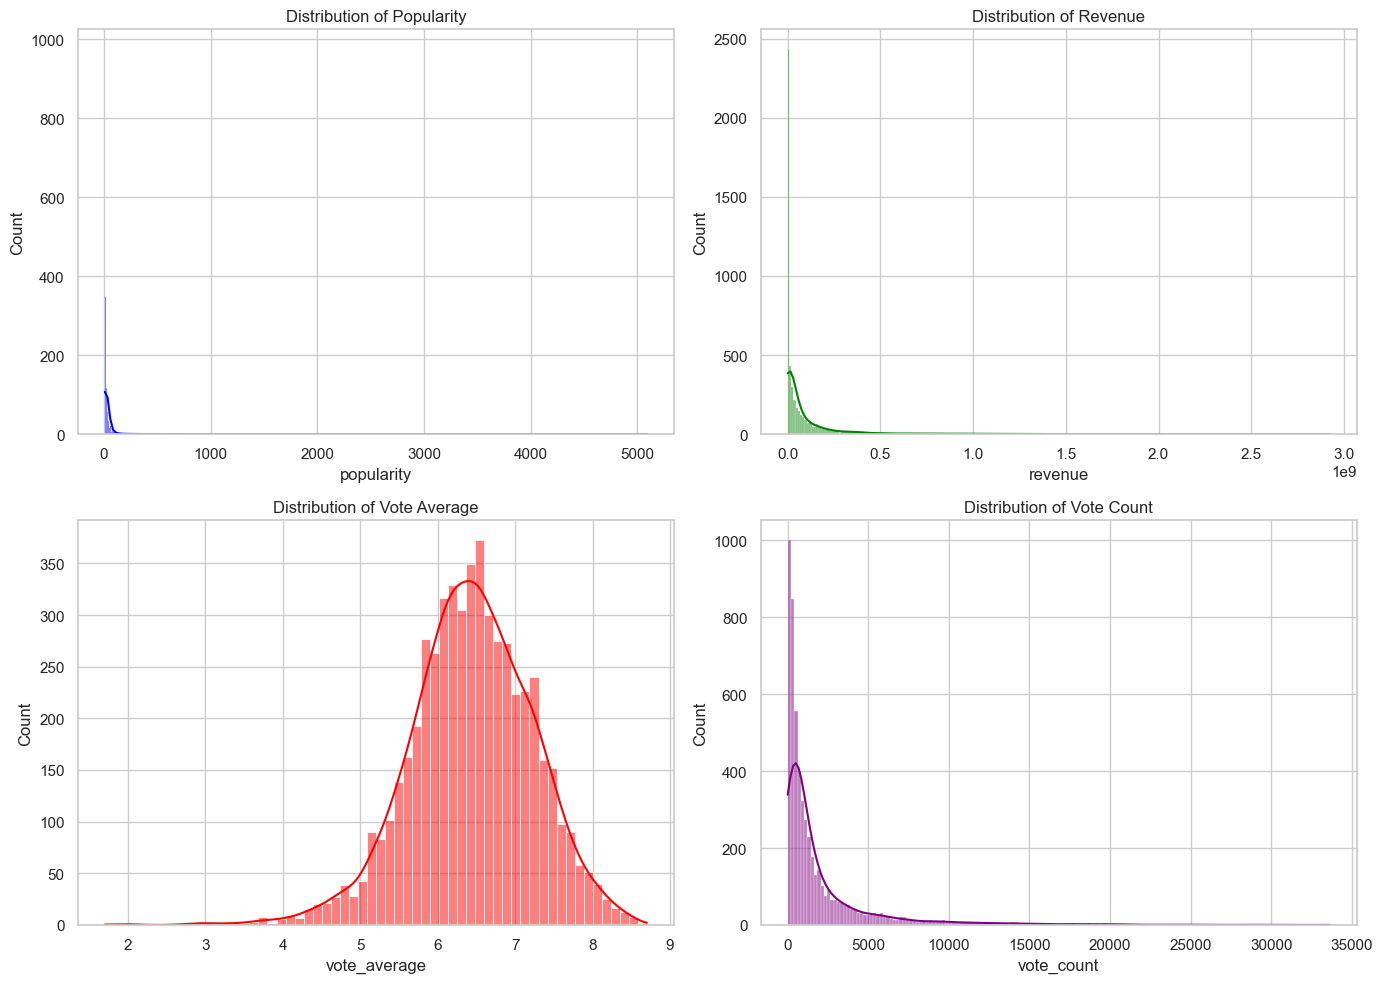

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Create a figure to hold the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')

# Plotting distributions of numerical features
sns.histplot(df['popularity'], ax=axes[0, 0], kde=True, color='blue')
axes[0, 0].set_title('Distribution of Popularity')

sns.histplot(df['revenue'], ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Distribution of Revenue')

sns.histplot(df['vote_average'], ax=axes[1, 0], kde=True, color='red')
axes[1, 0].set_title('Distribution of Vote Average')

sns.histplot(df['vote_count'], ax=axes[1, 1], kde=True, color='purple')
axes[1, 1].set_title('Distribution of Vote Count')

plt.tight_layout()
plt.show()

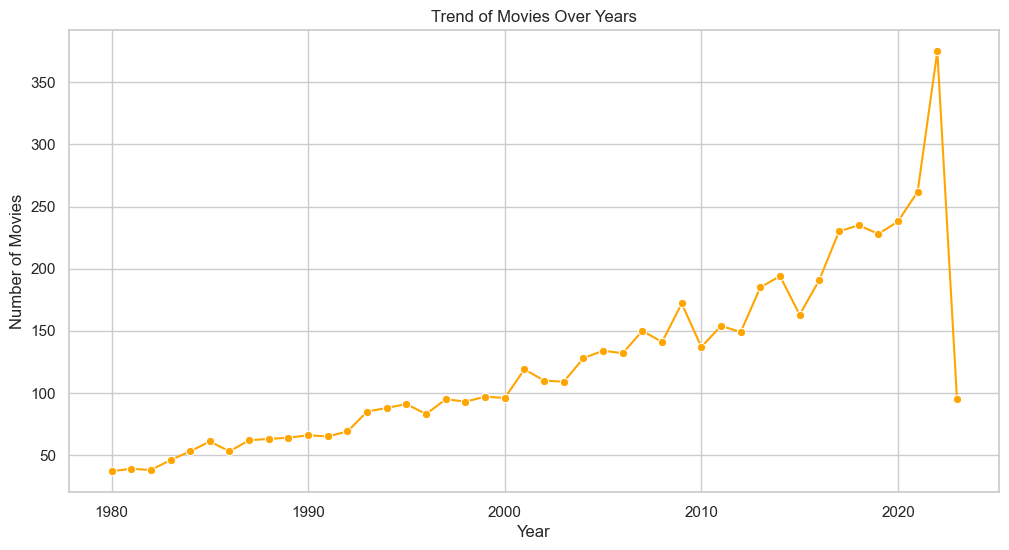

C:\Users\A406176\AppData\Local\Temp\ipykernel_15196\1970082157.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


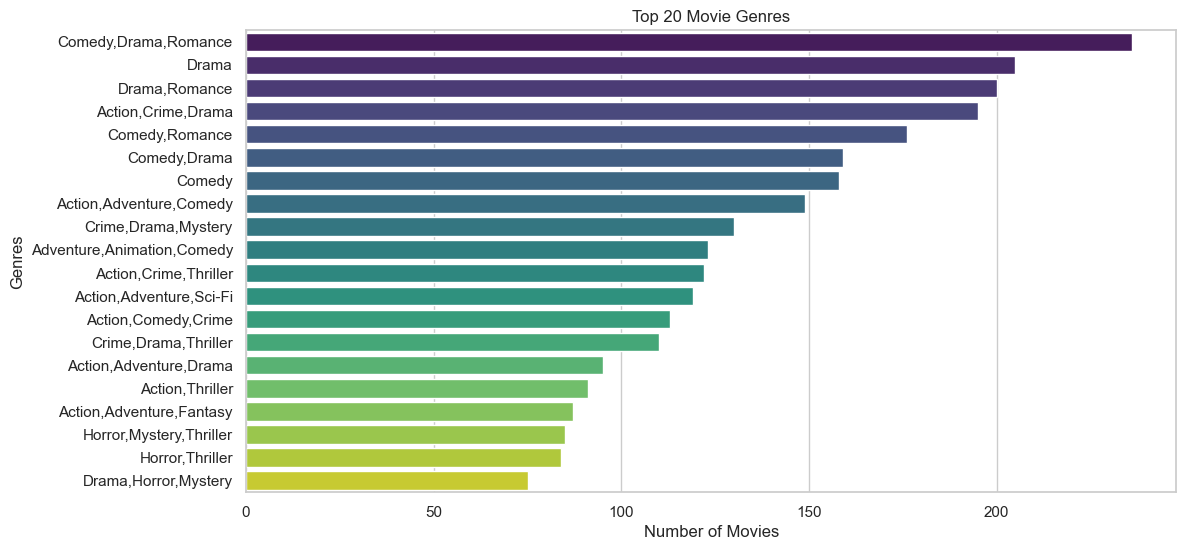

In [10]:
# Plotting trends over years
plt.figure(figsize=(12, 6), facecolor='white')
year_trend = df.groupby('Annee_Debut').size()
sns.lineplot(x=year_trend.index, y=year_trend.values, marker='o', color='orange')
plt.title('Trend of Movies Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

# Genre distribution
plt.figure(figsize=(12, 6), facecolor='white')
genre_counts = df['Genres'].value_counts().head(20)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 20 Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.show()

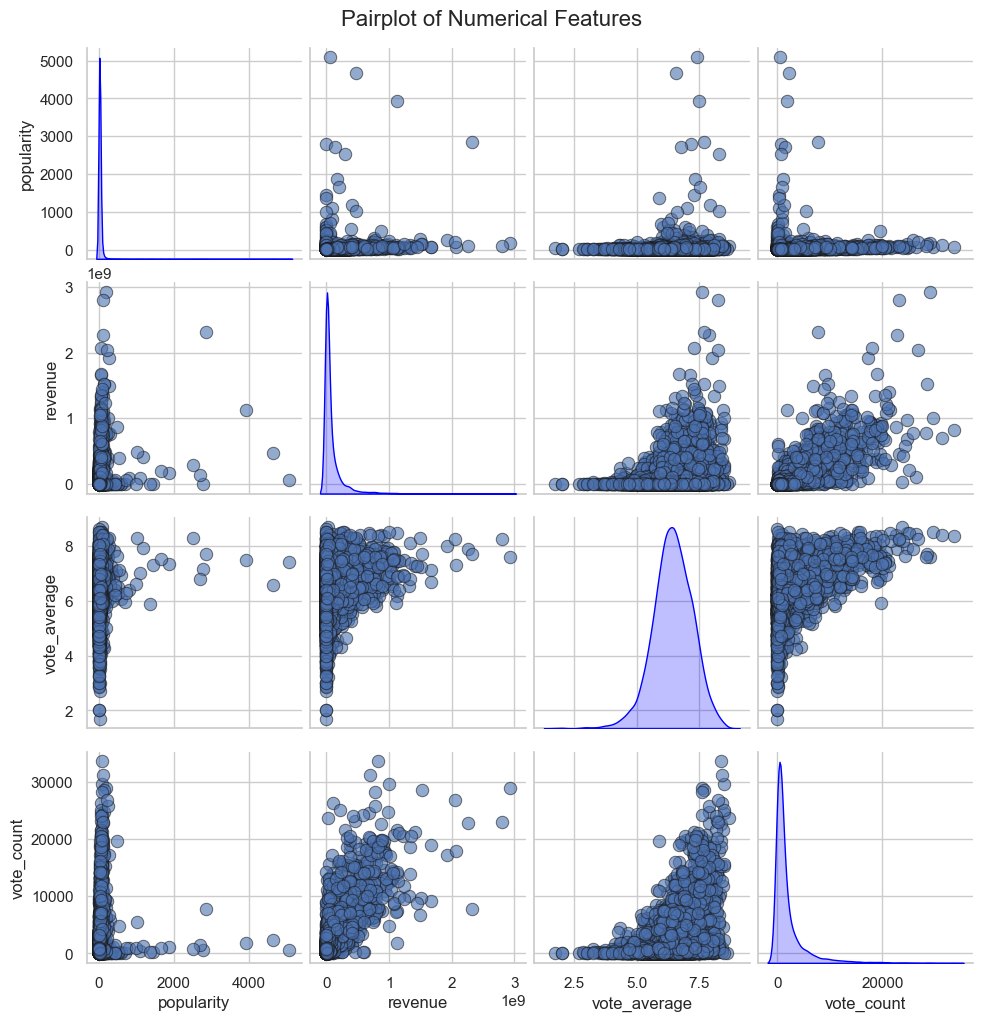

In [14]:
# Selecting a subset of numerical columns for the pairplot to avoid clutter
numerical_cols = ['popularity', 'revenue', 'vote_average', 'vote_count']

# Creating a pairplot with the selected columns
sns.pairplot(df[numerical_cols], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, diag_kws={'color': 'blue'})
plt.suptitle('Pairplot of Numerical Features', size=16, y=1.02)
plt.show()

In [13]:
# Creating new variables

df['revenue_per_vote'] = df['revenue'] / df['vote_count']
df['popularity_vote_ratio'] = df['popularity'] / df['vote_count']
df['overview_length'] = df['overview'].apply(len)
df['year_category'] = pd.cut(df['Annee_Debut'], bins=[1900, 1990, 2000, 2010, 2020, 2030], labels=['Before 1990', '1990s', '2000s', '2010s', '2020s'])
df['genre_count'] = df['Genres'].apply(lambda x: len(x.split(',')))

# Displaying the head of the dataframe to confirm the new variables
print(df[['revenue_per_vote', 'popularity_vote_ratio', 'overview_length', 'year_category', 'genre_count']].head())

   revenue_per_vote  popularity_vote_ratio  overview_length year_category  \
0       1806.259652               0.007948              237         1990s   
1      42735.697183               0.038018              403         1990s   
2      53352.370837               0.003909              333         2000s   
3      27543.923718               0.002127              238         1990s   
4      32505.848098               0.002407              175         1990s   

   genre_count  
0            1  
1            3  
2            3  
3            2  
4            1  


In [17]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Function to translate text from English to French
def translate_to_french(text):
    try:
        # Translate the text
        translation = translator.translate(text, src='en', dest='fr')
        return translation.text
    except Exception as e:
        return 'Translation Error: ' + str(e)

# Applying the translation function to the 'overview' column
# Note: This is a sample to show the translation process. For the entire column, batch processing would be more efficient.
df['overview_french'] = df['overview'].apply(translate_to_french)

# Displaying the translated overviews
print(df[['overview', 'overview_french']].head())

                                            overview  \
0  It's Ted the Bellhop's first night on the job....   
1  While racing to a boxing match, Frank, Mike, J...   
2  Nemo, an adventurous young clownfish, is unexp...   
3  A man with a low IQ has accomplished great thi...   
4  Lester Burnham, a depressed suburban father in...   

                                     overview_french  
0  C'est la première nuit de Bellhop au travail ....  
1  Tout en se dirigeant vers un match de boxe, Fr...  
2  Nemo, un jeune poisson-clown aventureux, est t...  
3  Un homme avec un QI faible a accompli de grand...  
4  Lester Burnham, un père de banlieue déprimé da...  


In [8]:
data = pd.read_csv('mon_dataframe.csv')
data

,imdb_id,overview,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,...,names,primaryProfessions,moyenne,nb_vote,revenue_per_vote,popularity_vote_ratio,overview_length,year_category,genre_count,overview_french
0,tt0113101,It's Ted the Bellhop's first night on the job....,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,...,"['Jennifer Beals', 'Ione Skye', 'Amanda De Cad...","['actress,producer,camera_department', 'actres...",6.7,110887.0,1806.259652,0.007948,237,1990s,1,C'est la première nuit de Bellhop au travail ....
1,tt0107286,"While racing to a boxing match, Frank, Mike, J...",10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",...,"['Henry Bogdan', 'Jere Cunningham', 'Corey Glo...","['actor,soundtrack', 'writer,producer', 'actor...",6.6,18732.0,42735.697183,0.038018,403,1990s,3,"Tout en se dirigeant vers un match de boxe, Fr..."
2,tt0266543,"Nemo, an adventurous young clownfish, is unexp...",68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",...,"['Ellen DeGeneres', 'Andrew Stanton', 'Brad Ga...","['producer,writer,actress', 'writer,producer,a...",8.2,1110161.0,53352.370837,0.003909,333,2000s,3,"Nemo, un jeune poisson-clown aventureux, est t..."
3,tt0109830,A man with a low IQ has accomplished great thi...,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",...,"['Tom Hanks', 'Sally Field', 'Gary Sinise', 'R...","['producer,actor,writer', 'actress,producer,di...",8.8,2248303.0,27543.923718,0.002127,238,1990s,2,Un homme avec un QI faible a accompli de grand...
4,tt0169547,"Lester Burnham, a depressed suburban father in...",26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,...,"['Kevin Spacey', 'Thora Birch', 'Paula Abdul',...","['actor,producer,writer', 'actress,producer,di...",8.3,1208340.0,32505.848098,0.002407,175,1990s,1,"Lester Burnham, un père de banlieue déprimé da..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,When Major Susan Turner is arrested for treaso...,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",...,"['Dan August', 'Jeff Babko', 'Robert Catrini',...","['camera_department,actor', 'music_department,...",6.1,174852.0,37283.530927,0.016431,176,2010s,3,Lorsque la majeure Susan Turner est arrêtée po...
5471,tt4649466,When an attack on the Kingsman headquarters ta...,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",...,"['John Denver', 'Paddy Eason', 'Elton John', '...","['music_artist,music_department,actor', 'visua...",6.7,361879.0,44302.173801,0.007527,192,2010s,3,Lorsqu'une attaque contre le siège de Kingsman...
5472,tt3748172,"When her husband's sex game goes wrong, Jessie...",15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",...,"['Carla Gugino', 'Armanda Costanza', ""David 'S...","['actress,producer,soundtrack', 'camera_depart...",6.5,126686.0,0.000000,0.004726,152,2010s,3,"Lorsque le jeu sexuel de son mari se trompe, J..."
5473,tt4337690,A man involved in a horrific car crash is pron...,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,...,"['David Clyde Carr', 'Michael Crider', 'Michae...","['actor', 'actor', 'music_artist,actor,compose...",4.9,4293.0,35871.844444,0.137030,140,2010s,1,Un homme impliqué dans un horrible accident de...


In [2]:
import pandas as pd

# Charger le fichier avec les imdb_id souhaités
desired_ids_df = pd.read_csv('mon_dataframe.csv')

# Extraire la liste des imdb_id (assurez-vous que la colonne s'appelle 'imdb_id')
desired_imdb_ids = set(desired_ids_df['imdb_id'].tolist())


In [5]:
chunks = []  # Liste pour garder les morceaux filtrés
chunk_size = 10000  # Taille de chaque morceau à lire

# Supposons que le fichier volumineux est nommé 'large_file.tsv' et qu'il a un séparateur de tabulation
for chunk in pd.read_csv('data-set/title.principals.tsv', sep='\t', chunksize=chunk_size):
    # Filtrer le chunk pour ne garder que les entrées avec les imdb_id souhaités
    filtered_chunk = chunk[chunk['tconst'].isin(desired_imdb_ids)]
    chunks.append(filtered_chunk)

# Concaténer tous les morceaux filtrés en un seul DataFrame
df_filtered = pd.concat(chunks)


In [7]:
df_filtered
# Sauvegarder le résultat dans un nouveau fichier CSV si nécessaire
df_filtered.to_csv('resultat_filtré.csv', index=False)


In [16]:
import pandas as pd

# Charger les données
df = pd.read_csv('resultat_filtré.csv')

# Fonction pour extraire les rôles requis
def extract_roles(group):
    roles = {'actor': [], 'director': None, 'producer': None, 'writer': None}
    
    # Filtrer pour acteurs, et trier selon 'ordering'
    actors = group[group['category'].isin(['actor', 'actress'])].sort_values(by='ordering')
    roles['actor'] = actors['nconst'].head(3).tolist()  # Prendre les trois premiers acteurs
    
    # Extraire les autres rôles principaux
    if 'director' in group['category'].values:
        roles['director'] = group[(group['category'] == 'director')].sort_values(by='ordering')['nconst'].iloc[0]
    if 'producer' in group['category'].values:
        roles['producer'] = group[(group['category'] == 'producer')].sort_values(by='ordering')['nconst'].iloc[0]
    if 'writer' in group['category'].values:
        roles['writer'] = group[(group['category'] == 'writer')].sort_values(by='ordering')['nconst'].iloc[0]

    return pd.Series(roles)

# Appliquer la fonction pour extraire les rôles par 'tconst'
result_df = df.groupby('tconst').apply(extract_roles).reset_index()

result_df


result_df.to_csv('final_roles.csv', index=False)



In [22]:
import pandas as pd

# Charger les DataFrames
mon_df = pd.read_csv('mon_dataframe.csv')
roles_df = pd.read_csv('final_roles.csv')  # Assurez-vous que c'est le bon chemin du fichier

# Afficher les noms de colonnes pour chaque DataFrame
print("Colonnes dans mon_dataframe.csv:", mon_df.columns)
print("Colonnes dans final_roles.csv:", roles_df.columns)


# Renommer la colonne si nécessaire
mon_df.rename(columns={'imdb_id': 'tconst'}, inplace=True)

# Effectuer la jointure
joined_df = pd.merge(mon_df, roles_df, on='tconst', how='left')





Colonnes dans mon_dataframe.csv: Index(['imdb_id', 'overview', 'popularity', 'revenue', 'vote_average',
       'vote_count', 'Titre_Principal', 'Annee_Debut', 'Duree_Minutes',
       'Genres', 'nconsts', 'names', 'primaryProfessions', 'moyenne',
       'nb_vote', 'revenue_per_vote', 'popularity_vote_ratio',
       'overview_length', 'year_category', 'genre_count', 'overview_french'],
      dtype='object')
Colonnes dans final_roles.csv: Index(['tconst', 'actor', 'director', 'producer', 'writer'], dtype='object')


In [34]:
joined_df.info()
joined_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tconst                      5475 non-null   object 
 1   overview                    5475 non-null   object 
 2   popularity                  5475 non-null   float64
 3   revenue                     5475 non-null   int64  
 4   vote_average                5475 non-null   float64
 5   vote_count                  5475 non-null   int64  
 6   Titre_Principal             5475 non-null   object 
 7   Annee_Debut                 5475 non-null   float64
 8   Duree_Minutes               5475 non-null   float64
 9   Genres                      5475 non-null   object 
 10  nconsts                     5473 non-null   object 
 11  names                       5473 non-null   object 
 12  primaryProfessions          5473 non-null   object 
 13  moyenne                     5475 

,tconst,overview,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,...,primaryName_producer,birthYear_producer,deathYear_producer,primaryProfession_producer,knownForTitles_producer,primaryName_writer,birthYear_writer,deathYear_writer,primaryProfession_writer,knownForTitles_writer
0,tt0113101,It's Ted the Bellhop's first night on the job....,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,...,Lawrence Bender,1957,\N,"producer,camera_department,actor","tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,1954,\N,"director,writer,producer","tt0104321,tt0113101,tt0173390,tt0245501"
1,tt0107286,"While racing to a boxing match, Frank, Mike, J...",10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",...,Gene Levy,\N,2022,"miscellaneous,production_manager,producer","tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,1951,\N,"writer,script_department","tt0132477,tt0349710,tt1438254"
2,tt0266543,"Nemo, an adventurous young clownfish, is unexp...",68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",...,Graham Walters,\N,\N,"visual_effects,producer,production_manager","tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,1965,\N,"writer,producer,actor","tt0910970,tt0266543,tt2277860,tt0120623"
3,tt0109830,A man with a low IQ has accomplished great thi...,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",...,Wendy Finerman,1961,\N,producer,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,1943,2020,"writer,actor,archive_footage","tt0109830,tt10028196,tt0156812,tt0090663"
4,tt0169547,"Lester Burnham, a depressed suburban father in...",26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,...,Bruce Cohen,\N,\N,"producer,assistant_director,actor","tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,1957,\N,"producer,writer,miscellaneous","tt0169547,tt0248654,tt0844441,tt11327514"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,When Major Susan Turner is arrested for treaso...,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",...,Tom Cruise,1962,\N,"actor,producer,director","tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,1956,\N,"writer,director,producer","tt0455944,tt17024450,tt1764651,tt3766354"
5471,tt4649466,When an attack on the Kingsman headquarters ta...,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",...,Adam Bohling,\N,\N,"producer,production_manager,location_management","tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,1970,\N,"producer,writer,actress","tt1250777,tt2802144,tt0486655,tt1596365"
5472,tt3748172,"When her husband's sex game goes wrong, Jessie...",15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",...,Trevor Macy,\N,\N,"producer,writer","tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,1978,\N,"director,writer,editor","tt15567174,tt6763664,tt10574558,tt5606664"
5473,tt4337690,A man involved in a horrific car crash is pron...,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,...,Randall Emmett,1971,\N,"producer,director,writer","tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,1970,\N,"director,writer,producer","tt0162830,tt0322659,tt0261755,tt1462411"


In [35]:
result_df

,tconst,actor,director,producer,writer
0,tt0035423,"[nm0000212, nm0413168, nm0000630]",nm0003506,nm0465298,nm0737216
1,tt0078935,"[nm0449404, nm0161889, nm0685194]",nm0219959,None,nm0166405
2,tt0080164,"[nm0001321, nm0197714, nm0000577]",nm0434211,nm0487190,nm0402848
3,tt0080310,"[nm0940919, nm0860233, nm0914113]",nm0000915,nm0140929,nm0362682
4,tt0080354,"[nm0001233, nm0726939, nm0311155]",nm0853546,nm0153699,nm0000626
...,...,...,...,...,...
5470,tt9887580,"[nm0522324, nm0289105, nm0865302]",nm0666806,nm0254291,nm0666806
5471,tt9893250,"[nm0683253, nm0227759, nm2555462]",nm2128335,nm2128335,nm2128335
5472,tt9894470,"[nm0002332, nm0006669, nm0004365]",nm3976308,nm3991275,nm2244274
5473,tt9896916,"[nm0861657, nm0722636, nm6717788]",nm4775123,nm9526002,nm0963344


In [28]:
import pandas as pd

# Charger les DataFrames
joined_df = pd.read_csv('joined_dataframe.csv')
name_basics = pd.read_csv('data-set/name.basics.csv',sep='\t')  # Assurez-vous que c'est le bon chemin du fichier


In [29]:
def replace_nconst_with_name(df, column_name):
    # Si la colonne est 'actor', préparer pour traiter plusieurs acteurs
    if column_name == 'actor':
        # Transformer la chaîne d'acteurs en liste et l'explorer
        expanded_actors = df[column_name].str.split(',', expand=True)
        # Créer une copie temporaire du DataFrame pour éviter les modifications en place
        temp_df = df.copy()
        # Appliquer la jointure pour chaque acteur trouvé
        for i in range(expanded_actors.shape[1]):
            # Fusionner avec name_basics en s'assurant que les suffixes sont correctement gérés
            temp_df = temp_df.merge(name_basics, how='left', left_on=expanded_actors[i].fillna(''), right_on='nconst',
                                    suffixes=('', f'_actor{i}'))
            # Renommer la colonne de nom correctement pour chaque acteur
            temp_df.rename(columns={'name': f'actor{i}'}, inplace=True)
            # Supprimer les colonnes nconst créées lors de la jointure
            temp_df.drop(columns=['nconst'], inplace=True)
        return temp_df
    else:
        # Fusionner avec name_basics pour les autres rôles, en utilisant des suffixes distincts
        temp_df = df.merge(name_basics, how='left', left_on=column_name, right_on='nconst',
                        suffixes=('', f'_{column_name}'))
        # Renommer et supprimer les colonnes
        temp_df.rename(columns={'name': column_name}, inplace=True)
        temp_df.drop(columns=['nconst', f'{column_name}_{column_name}'], errors='ignore', inplace=True)
        return temp_df

# Appliquer la fonction pour chaque rôle
for role in ['actor', 'director', 'producer', 'writer']:
    joined_df = replace_nconst_with_name(joined_df, role)


In [32]:
import pandas as pd
import ast  # Pour convertir les chaînes en listes

# Charger votre DataFrame (joined_dataframe.csv)
df = pd.read_csv('joined_dataframe.csv')

# Charger la table de correspondance des noms (name_basics.csv)
name_basics = pd.read_csv('data-set/name.basics.csv',sep='\t')  # Assurez-vous que le chemin est correct

# Fonction pour convertir des chaînes représentant des listes en listes réelles
def convert_string_to_list(string):
    try:
        return ast.literal_eval(string)
    except ValueError:
        return []  # Retourne une liste vide en cas d'erreur

# Convertir les chaînes en listes
df['actor'] = df['actor'].apply(convert_string_to_list)

# Éclater les listes pour que chaque acteur ait sa propre ligne
df = df.explode('actor')

# Joindre avec la table des noms pour obtenir les noms correspondants aux nconst
df = df.merge(name_basics[['nconst', 'primaryName']], left_on='actor', right_on='nconst', how='left')

# Remplacer les identifiants par des noms
df['actor'] = df['primaryName']

# Supprimer les colonnes temporaires
df.drop(['nconst', 'primaryName'], axis=1, inplace=True)

# Regrouper les données par film et agréger les acteurs en une liste
df = df.groupby('tconst').agg({
    'actor': lambda x: list(x),
    # Ajoutez ici d'autres colonnes nécessaires à agréger
}).reset_index()

# Sauvegarder les résultats
df



,tconst,actor
0,tt0035423,"[Meg Ryan, Hugh Jackman, Liev Schreiber]"
1,tt0078935,"[Robert Kerman, Francesca Ciardi, Perry Pirkanen]"
2,tt0080164,"[Richard Harris, Jennifer Dale, George Peppard]"
3,tt0080310,"[Edward Woodward, Jack Thompson, John Waters]"
4,tt0080354,"[Robert Forster, Robin Riker, Michael V. Gazzo]"
...,...,...
5470,tt9887580,"[Faizon Love, Kirk Fox, Tony Todd]"
5471,tt9893250,"[Rosamund Pike, Peter Dinklage, Eiza González]"
5472,tt9894470,"[Stephen Lang, William Sadler, Fred Williamson]"
5473,tt9896916,"[David Thorpe, John Rhys-Davies, Kristyn Getty]"


In [52]:
import pandas as pd


# Effectuer la jointure sur 'tconst'
final_df = pd.merge(joined_df, df, on='tconst', how='left')

final_df = final_df.rename(columns={
    'actor_x': 'actor_ids',  # Les identifiants originaux d'acteurs, si nécessaire
    'actor_y': 'actor_names'  # Les noms des acteurs
})


# Afficher le début du DataFrame final pour vérifier
final_df


,tconst,overview,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,...,birthYear_producer,deathYear_producer,primaryProfession_producer,knownForTitles_producer,primaryName_writer,birthYear_writer,deathYear_writer,primaryProfession_writer,knownForTitles_writer,actor_names
0,tt0113101,It's Ted the Bellhop's first night on the job....,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,...,1957,\N,"producer,camera_department,actor","tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,1954,\N,"director,writer,producer","tt0104321,tt0113101,tt0173390,tt0245501","[Tim Roth, Antonio Banderas, Sammi Davis]"
1,tt0107286,"While racing to a boxing match, Frank, Mike, J...",10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",...,\N,2022,"miscellaneous,production_manager,producer","tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,1951,\N,"writer,script_department","tt0132477,tt0349710,tt1438254","[Emilio Estevez, Cuba Gooding Jr., Denis Leary]"
2,tt0266543,"Nemo, an adventurous young clownfish, is unexp...",68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",...,\N,\N,"visual_effects,producer,production_manager","tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,1965,\N,"writer,producer,actor","tt0910970,tt0266543,tt2277860,tt0120623","[Albert Brooks, Ellen DeGeneres, Alexander Gould]"
3,tt0109830,A man with a low IQ has accomplished great thi...,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",...,1961,\N,producer,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,1943,2020,"writer,actor,archive_footage","tt0109830,tt10028196,tt0156812,tt0090663","[Tom Hanks, Robin Wright, Gary Sinise]"
4,tt0169547,"Lester Burnham, a depressed suburban father in...",26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,...,\N,\N,"producer,assistant_director,actor","tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,1957,\N,"producer,writer,miscellaneous","tt0169547,tt0248654,tt0844441,tt11327514","[Kevin Spacey, Annette Bening, Thora Birch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,When Major Susan Turner is arrested for treaso...,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",...,1962,\N,"actor,producer,director","tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,1956,\N,"writer,director,producer","tt0455944,tt17024450,tt1764651,tt3766354","[Tom Cruise, Cobie Smulders, Aldis Hodge]"
5471,tt4649466,When an attack on the Kingsman headquarters ta...,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",...,\N,\N,"producer,production_manager,location_management","tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,1970,\N,"producer,writer,actress","tt1250777,tt2802144,tt0486655,tt1596365","[Taron Egerton, Colin Firth, Mark Strong]"
5472,tt3748172,"When her husband's sex game goes wrong, Jessie...",15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",...,\N,\N,"producer,writer","tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,1978,\N,"director,writer,editor","tt15567174,tt6763664,tt10574558,tt5606664","[Carla Gugino, Bruce Greenwood, Chiara Aurelia]"
5473,tt4337690,A man involved in a horrific car crash is pron...,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,...,1971,\N,"producer,director,writer","tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,1970,\N,"director,writer,producer","tt0162830,tt0322659,tt0261755,tt1462411","[Kate Bosworth, Hayden Christensen, Hudson Meek]"


In [53]:
import pandas as pd


# Liste des colonnes à supprimer
columns_to_drop = ['primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles',
                   'primaryName_actor1', 'birthYear_actor1', 'deathYear_actor1', 'primaryProfession_actor1', 'knownForTitles_actor1',
                   'primaryName_actor2', 'birthYear_actor2', 'deathYear_actor2', 'primaryProfession_actor2', 'knownForTitles_actor2',
                   'birthYear_director','deathYear_director','primaryProfession_director','birthYear_producer','deathYear_producer',
                   'primaryProfession_producer','birthYear_writer','deathYear_writer','deathYear_writer','primaryProfession_writer','overview_length','overview','nconsts','names','primaryProfessions'
                   ]

# Supprimer les colonnes
final_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

final_df

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,director,producer,writer,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,actor_names
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,nm0025978,nm0004744,nm0025978,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501","[Tim Roth, Antonio Banderas, Sammi Davis]"
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,nm0394280,nm0506420,nm0171474,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254","[Emilio Estevez, Cuba Gooding Jr., Denis Leary]"
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,nm0004056,nm0910237,nm0004056,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623","[Albert Brooks, Ellen DeGeneres, Alexander Gould]"
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,nm0000709,nm0277704,nm0343165,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663","[Tom Hanks, Robin Wright, Gary Sinise]"
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,nm0005222,nm0169260,nm0050332,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514","[Kevin Spacey, Annette Bening, Thora Birch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,nm0001880,nm0000129,nm0921013,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354","[Tom Cruise, Cobie Smulders, Aldis Hodge]"
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,nm0891216,nm0092061,nm0963359,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365","[Taron Egerton, Colin Firth, Mark Strong]"
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,nm1093039,nm1006167,nm1093039,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664","[Carla Gugino, Bruce Greenwood, Chiara Aurelia]"
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,nm0689187,nm0256542,nm0689187,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411","[Kate Bosworth, Hayden Christensen, Hudson Meek]"


In [54]:
filtered_df = final_df[final_df['moyenne'] >= 4.5]
filtered_df = final_df[final_df['Annee_Debut'] >= 1990]
filtered_df

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,director,producer,writer,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,actor_names
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,nm0025978,nm0004744,nm0025978,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501","[Tim Roth, Antonio Banderas, Sammi Davis]"
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,nm0394280,nm0506420,nm0171474,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254","[Emilio Estevez, Cuba Gooding Jr., Denis Leary]"
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,nm0004056,nm0910237,nm0004056,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623","[Albert Brooks, Ellen DeGeneres, Alexander Gould]"
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,nm0000709,nm0277704,nm0343165,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663","[Tom Hanks, Robin Wright, Gary Sinise]"
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,nm0005222,nm0169260,nm0050332,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514","[Kevin Spacey, Annette Bening, Thora Birch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,nm0001880,nm0000129,nm0921013,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354","[Tom Cruise, Cobie Smulders, Aldis Hodge]"
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,nm0891216,nm0092061,nm0963359,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365","[Taron Egerton, Colin Firth, Mark Strong]"
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,nm1093039,nm1006167,nm1093039,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664","[Carla Gugino, Bruce Greenwood, Chiara Aurelia]"
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,nm0689187,nm0256542,nm0689187,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411","[Kate Bosworth, Hayden Christensen, Hudson Meek]"


In [59]:

final_df
df.to_csv('final_df.csv', index=False)

In [118]:
 final_df

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,director,producer,writer,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,actor_names
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,nm0025978,nm0004744,nm0025978,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501","[Tim Roth, Antonio Banderas, Sammi Davis]"
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,nm0394280,nm0506420,nm0171474,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254","[Emilio Estevez, Cuba Gooding Jr., Denis Leary]"
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,nm0004056,nm0910237,nm0004056,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623","[Albert Brooks, Ellen DeGeneres, Alexander Gould]"
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,nm0000709,nm0277704,nm0343165,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663","[Tom Hanks, Robin Wright, Gary Sinise]"
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,nm0005222,nm0169260,nm0050332,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514","[Kevin Spacey, Annette Bening, Thora Birch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,nm0001880,nm0000129,nm0921013,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354","[Tom Cruise, Cobie Smulders, Aldis Hodge]"
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,nm0891216,nm0092061,nm0963359,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365","[Taron Egerton, Colin Firth, Mark Strong]"
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,nm1093039,nm1006167,nm1093039,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664","[Carla Gugino, Bruce Greenwood, Chiara Aurelia]"
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,nm0689187,nm0256542,nm0689187,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411","[Kate Bosworth, Hayden Christensen, Hudson Meek]"


In [135]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Charger les données
df = pd.read_csv('final_df.csv')  # Assurez-vous de mettre le bon chemin d'accès au fichier



# Préparer les genres pour la vectorisation
df['Genres'] = df['Genres'].fillna('')  # Remplacer les valeurs NaN par une chaîne vide

# Convertir les genres en vecteurs TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
genre_matrix = tfidf.fit_transform(df['overview_french'])

# Calculer la matrice de similarité cosinus
cosine_sim = cosine_similarity(genre_matrix, genre_matrix)

# Fonction pour obtenir des recommandations basées sur la similarité de genre
def get_recommendations(title, cosine_sim=cosine_sim):
    # Trouver l'index du film donné
    idx = df[df['Titre_Principal'] == title].index[0]

    # Récupérer les scores de similarité pour ce film par rapport à tous les autres
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Trier les films en fonction des scores de similarité, du plus élevé au plus bas
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Récupérer les indices des 10 films les plus similaires
    top_indices = [i[0] for i in sim_scores[1:11]]  # Exclure le premier car il s'agit du film lui-même

    # Retourner les titres des films les plus similaires
    return df['Titre_Principal'].iloc[top_indices]

# Test de la fonction de recommandation pour 'Forrest Gump'
recommended_titles = get_recommendations('Boogeyman 3')
print(recommended_titles)


3428                   Body Cam
3163               Castle Freak
2730    Other People's Children
2579               Consecration
347           The Good Shepherd
630           What Lies Beneath
434                 The Reaping
2789                  9 Bullets
4509    Silent Hill: Revelation
1304               Urban Legend
Name: Titre_Principal, dtype: object


In [6]:
import pandas as pd

# Charger le fichier dans un DataFrame
df = pd.read_csv('photo_film.csv')  # Remplacez 'chemin_du_fichier.csv' par le chemin de votre fichier

# Sélectionner uniquement les colonnes spécifiques
colonnes_a_garder = ['backdrop_path', 'imdb_id', 'homepage', 'poster_path']
df_filtré = df[colonnes_a_garder]

# Ajouter l'URL devant chaque entrée dans la colonne 'poster_path'
url_prefix = "https://image.tmdb.org/t/p/original"
df_filtré['poster_path'] = df_filtré['poster_path'].apply(lambda x: url_prefix + x if pd.notna(x) else x)

# Sauvegarder le nouveau DataFrame si nécessaire
df_filtré.to_csv('photo_de_film.csv', index=False)


In [9]:
import pandas as pd

# Chargement des données
tmdb_data = pd.read_csv('photo_de _film.csv')
final_df = pd.read_csv('final_df.csv')

# Effectuer la jointure
combined_data = pd.merge(final_df, tmdb_data, left_on='tconst', right_on='imdb_id', how='left')
combined_data

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,backdrop_path,imdb_id,homepage,poster_path
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",/c1BaOxC8bo5ACFYkYYxL0bBWRaq.jpg,tt0113101,https://www.miramax.com/movie/four-rooms/,https://image.tmdb.org/t/p/original/75aHn1NOYX...
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254",/bGMqHn0H2UY6SPZ5Vch4YJM2jDO.jpg,tt0107286,NaN,https://image.tmdb.org/t/p/original/3rvvpS9YPM...
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",/yzqaKAhglTrkeOfuIXYYArf0WnA.jpg,tt0266543,http://movies.disney.com/finding-nemo,https://image.tmdb.org/t/p/original/5lc6nQc0Vh...
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663",/3h1JZGDhZ8nzxdgvkxha0qBqi05.jpg,tt0109830,https://www.paramountmovies.com/movies/forrest...,https://image.tmdb.org/t/p/original/arw2vcBveW...
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514",/DztBnZaqmla2sGUW9s8AyOmskT.jpg,tt0169547,NaN,https://image.tmdb.org/t/p/original/wby9315QzV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354",/ww1eIoywghjoMzRLRIcbJLuKnJH.jpg,tt3393786,NaN,https://image.tmdb.org/t/p/original/cOg3UT2NYW...
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365",/eVHVwP71el20fofkCHo78ebQv7Q.jpg,tt4649466,http://www.foxmovies.com/movies/kingsman-the-g...,https://image.tmdb.org/t/p/original/34xBL6BXNY...
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",/jEVli6w9HNFjVMwJyzNH2bPMx7G.jpg,tt3748172,https://www.netflix.com/title/80128722,https://image.tmdb.org/t/p/original/32dippiypD...
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",/iOzIbK2w0LTZOZZoDKPT6GARMQi.jpg,tt4337690,NaN,https://image.tmdb.org/t/p/original/e3LKk8UdDy...


In [12]:
url_prefix = "https://image.tmdb.org/t/p/original"
combined_data['backdrop_path'] = combined_data['backdrop_path'].apply(lambda x: url_prefix + x if pd.notna(x) else x)
combined_data

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,backdrop_path,imdb_id,homepage,poster_path
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",https://image.tmdb.org/t/p/original/c1BaOxC8bo...,tt0113101,https://www.miramax.com/movie/four-rooms/,https://image.tmdb.org/t/p/original/75aHn1NOYX...
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254",https://image.tmdb.org/t/p/original/bGMqHn0H2U...,tt0107286,NaN,https://image.tmdb.org/t/p/original/3rvvpS9YPM...
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",https://image.tmdb.org/t/p/original/yzqaKAhglT...,tt0266543,http://movies.disney.com/finding-nemo,https://image.tmdb.org/t/p/original/5lc6nQc0Vh...
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663",https://image.tmdb.org/t/p/original/3h1JZGDhZ8...,tt0109830,https://www.paramountmovies.com/movies/forrest...,https://image.tmdb.org/t/p/original/arw2vcBveW...
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514",https://image.tmdb.org/t/p/original/DztBnZaqml...,tt0169547,NaN,https://image.tmdb.org/t/p/original/wby9315QzV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354",https://image.tmdb.org/t/p/original/ww1eIoywgh...,tt3393786,NaN,https://image.tmdb.org/t/p/original/cOg3UT2NYW...
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365",https://image.tmdb.org/t/p/original/eVHVwP71el...,tt4649466,http://www.foxmovies.com/movies/kingsman-the-g...,https://image.tmdb.org/t/p/original/34xBL6BXNY...
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",https://image.tmdb.org/t/p/original/jEVli6w9HN...,tt3748172,https://www.netflix.com/title/80128722,https://image.tmdb.org/t/p/original/32dippiypD...
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",https://image.tmdb.org/t/p/original/iOzIbK2w0L...,tt4337690,NaN,https://image.tmdb.org/t/p/original/e3LKk8UdDy...


In [13]:
# Compter les valeurs manquantes par colonne
missing_values_count = combined_data.isna().sum()
print(missing_values_count)


tconst                        0
popularity                    0
revenue                       0
vote_average                  0
vote_count                    0
Titre_Principal               0
Annee_Debut                   0
Duree_Minutes                 0
Genres                        0
moyenne                       0
nb_vote                       0
revenue_per_vote              0
popularity_vote_ratio         0
year_category                 0
genre_count                   0
overview_french               0
actor_ids                     0
actor_names                   0
director                      4
producer                     39
writer                        3
primaryName_director          4
knownForTitles_director       4
primaryName_producer         39
knownForTitles_producer      39
primaryName_writer            3
knownForTitles_writer         3
backdrop_path                 9
imdb_id                       0
homepage                   3088
poster_path                   0
dtype: i

In [16]:
# Afficher les lignes où 'backdrop_path' est manquant
missing_backdrop_rows = combined_data[combined_data['backdrop_path'].isna()]
print(missing_backdrop_rows)


          tconst  popularity  revenue  vote_average  vote_count  \
2416  tt16301792      20.145   128759         4.600           4   
2621  tt11641654      12.143        0         8.065         138   
4284   tt0905357      13.569        0         5.526          19   
4542   tt0238627      13.399        0         7.115          87   
4766   tt0292223      15.938        0         3.750           4   
4768   tt0336564      10.160        0         3.000           3   
4947   tt0112310      35.911        0         3.800           4   
5020   tt0378884      11.564        0         4.900           4   
5321   tt2392385      17.061        0         4.300          64   

                 Titre_Principal  Annee_Debut  Duree_Minutes  \
2416  La Usurpadora: The Musical       2023.0          115.0   
2621           Gabriel's Rapture       2021.0          106.0   
4284                      Normal       2007.0          100.0   
4542                  Attraction       2000.0           95.0   
4766     

In [18]:
# Supprimer les lignes où 'backdrop_path' est manquant
cleaned_data = combined_data.dropna(subset=['backdrop_path'])

# Vérifiez que les lignes ont été supprimées correctement
print("Nombre de lignes après suppression:", cleaned_data.shape[0])

# Afficher un aperçu pour confirmer que les lignes manquantes ont été supprimées
print(cleaned_data['backdrop_path'].isna().sum())

Nombre de lignes après suppression: 5466
0


In [19]:
missing_values_count = cleaned_data.isna().sum()
print(missing_values_count)



tconst                        0
popularity                    0
revenue                       0
vote_average                  0
vote_count                    0
Titre_Principal               0
Annee_Debut                   0
Duree_Minutes                 0
Genres                        0
moyenne                       0
nb_vote                       0
revenue_per_vote              0
popularity_vote_ratio         0
year_category                 0
genre_count                   0
overview_french               0
actor_ids                     0
actor_names                   0
director                      4
producer                     38
writer                        2
primaryName_director          4
knownForTitles_director       4
primaryName_producer         38
knownForTitles_producer      38
primaryName_writer            2
knownForTitles_writer         2
backdrop_path                 0
imdb_id                       0
homepage                   3080
poster_path                   0
dtype: i

In [21]:
# Supprimer les colonnes 'imdb_id' et 'homepage'
cleaned_data = combined_data.drop(['imdb_id', 'homepage'], axis=1)
cleaned_data

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,producer,writer,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,backdrop_path,poster_path
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,nm0004744,nm0025978,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",https://image.tmdb.org/t/p/original/c1BaOxC8bo...,https://image.tmdb.org/t/p/original/75aHn1NOYX...
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,nm0506420,nm0171474,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254",https://image.tmdb.org/t/p/original/bGMqHn0H2U...,https://image.tmdb.org/t/p/original/3rvvpS9YPM...
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,nm0910237,nm0004056,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",https://image.tmdb.org/t/p/original/yzqaKAhglT...,https://image.tmdb.org/t/p/original/5lc6nQc0Vh...
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,nm0277704,nm0343165,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663",https://image.tmdb.org/t/p/original/3h1JZGDhZ8...,https://image.tmdb.org/t/p/original/arw2vcBveW...
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,nm0169260,nm0050332,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514",https://image.tmdb.org/t/p/original/DztBnZaqml...,https://image.tmdb.org/t/p/original/wby9315QzV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,nm0000129,nm0921013,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354",https://image.tmdb.org/t/p/original/ww1eIoywgh...,https://image.tmdb.org/t/p/original/cOg3UT2NYW...
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,nm0092061,nm0963359,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365",https://image.tmdb.org/t/p/original/eVHVwP71el...,https://image.tmdb.org/t/p/original/34xBL6BXNY...
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,nm1006167,nm1093039,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",https://image.tmdb.org/t/p/original/jEVli6w9HN...,https://image.tmdb.org/t/p/original/32dippiypD...
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,nm0256542,nm0689187,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",https://image.tmdb.org/t/p/original/iOzIbK2w0L...,https://image.tmdb.org/t/p/original/e3LKk8UdDy...


In [22]:
cleaned_data.to_csv('df_final.csv', index=False)

In [23]:
df = pd.read_csv('df_final.csv')
df

,tconst,popularity,revenue,vote_average,vote_count,Titre_Principal,Annee_Debut,Duree_Minutes,Genres,moyenne,...,producer,writer,primaryName_director,knownForTitles_director,primaryName_producer,knownForTitles_producer,primaryName_writer,knownForTitles_writer,backdrop_path,poster_path
0,tt0113101,18.734,4257354,5.758,2357,Four Rooms,1995.0,98.0,Comedy,6.7,...,nm0004744,nm0025978,Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",Lawrence Bender,"tt0110912,tt0266697,tt0105236,tt0361748",Allison Anders,"tt0104321,tt0113101,tt0173390,tt0245501",https://image.tmdb.org/t/p/original/c1BaOxC8bo...,https://image.tmdb.org/t/p/original/75aHn1NOYX...
1,tt0107286,10.797,12136938,6.600,284,Judgment Night,1993.0,110.0,"Action,Crime,Drama",6.6,...,nm0506420,nm0171474,Stephen Hopkins,"tt0120738,tt0097981,tt0100403,tt0352520",Gene Levy,"tt0114898,tt0083511,tt0083190,tt0112722",Lewis Colick,"tt0132477,tt0349710,tt1438254",https://image.tmdb.org/t/p/original/bGMqHn0H2U...,https://image.tmdb.org/t/p/original/3rvvpS9YPM...
2,tt0266543,68.898,940335536,7.823,17625,Finding Nemo,2003.0,100.0,"Adventure,Animation,Comedy",8.2,...,nm0910237,nm0004056,Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",Graham Walters,"tt0266543,tt0105629,tt0120623,tt0114709",Andrew Stanton,"tt0910970,tt0266543,tt2277860,tt0120623",https://image.tmdb.org/t/p/original/yzqaKAhglT...,https://image.tmdb.org/t/p/original/5lc6nQc0Vh...
3,tt0109830,52.321,677387716,8.481,24593,Forrest Gump,1994.0,142.0,"Drama,Romance",8.8,...,nm0277704,nm0343165,Robert Zemeckis,"tt0088763,tt0109830,tt0118884,tt1907668",Wendy Finerman,"tt0109830,tt0303933,tt1598828,tt0116277",Winston Groom,"tt0109830,tt10028196,tt0156812,tt0090663",https://image.tmdb.org/t/p/original/3h1JZGDhZ8...,https://image.tmdb.org/t/p/original/arw2vcBveW...
4,tt0169547,26.384,356296601,8.027,10961,American Beauty,1999.0,122.0,Drama,8.3,...,nm0169260,nm0050332,Sam Mendes,"tt8579674,tt0257044,tt1074638,tt0959337",Bruce Cohen,"tt0169547,tt1045658,tt1013753,tt0109813",Alan Ball,"tt0169547,tt0248654,tt0844441,tt11327514",https://image.tmdb.org/t/p/original/DztBnZaqml...,https://image.tmdb.org/t/p/original/wby9315QzV...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5470,tt3393786,71.458,162146076,5.930,4349,Jack Reacher: Never Go Back,2016.0,118.0,"Action,Crime,Drama",6.1,...,nm0000129,nm0921013,Edward Zwick,"tt0325710,tt0092492,tt0138097,tt0115956",Tom Cruise,"tt0092099,tt0325710,tt0116695,tt0120755",Richard Wenk,"tt0455944,tt17024450,tt1764651,tt3766354",https://image.tmdb.org/t/p/original/ww1eIoywgh...,https://image.tmdb.org/t/p/original/cOg3UT2NYW...
5471,tt4649466,69.810,410902662,6.977,9275,Kingsman: The Golden Circle,2017.0,141.0,"Action,Adventure,Comedy",6.7,...,nm0092061,nm0963359,Matthew Vaughn,"tt1250777,tt1270798,tt2802144,tt0375912",Adam Bohling,"tt2066051,tt2802144,tt0375912,tt15009428",Jane Goldman,"tt1250777,tt2802144,tt0486655,tt1596365",https://image.tmdb.org/t/p/original/eVHVwP71el...,https://image.tmdb.org/t/p/original/34xBL6BXNY...
5472,tt3748172,15.402,0,6.391,3259,Gerald's Game,2017.0,103.0,"Drama,Horror,Thriller",6.5,...,nm1006167,nm1093039,Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",Trevor Macy,"tt2388715,tt6763664,tt5606664,tt0482606",Mike Flanagan,"tt15567174,tt6763664,tt10574558,tt5606664",https://image.tmdb.org/t/p/original/jEVli6w9HN...,https://image.tmdb.org/t/p/original/32dippiypD...
5473,tt4337690,18.499,4842699,6.089,135,90 Minutes in Heaven,2015.0,121.0,Drama,4.9,...,nm0256542,nm0689187,Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",Randall Emmett,"tt0490215,tt1302006,tt7638348,tt1855199",Michael Polish,"tt0162830,tt0322659,tt0261755,tt1462411",https://image.tmdb.org/t/p/original/iOzIbK2w0L...,https://image.tmdb.org/t/p/original/e3LKk8UdDy...


In [1]:
import pandas as pd

# Lire le fichier film_ml.parquet
film_ml_df = pd.read_parquet('film_ml.parquet')

# Afficher les premières lignes du DataFrame pour vérifier le contenu
print(film_ml_df.head())


       title_id title_type             title_used           title_orginal  \
384   tt0988045      movie        Sherlock Holmes         Sherlock Holmes   
486  tt10958282      movie            Street Flow            Banlieusards   
522   tt0256627      movie                Azzurro                 Azzurro   
617   tt2332514      movie  The Girl from Nowhere  La fille de nulle part   
745   tt9738784      movie        Persian Lessons         Persischstunden   

     title_release_year               title_backdrop_path  title_budget  \
384                2009  /veXdzn7LL0bFIDGmE7tTkvRg0qV.jpg    90000000.0   
486                2019  /jH1f7VaYtMCyqgJRoG7lCg8krxO.jpg     2700000.0   
522                2000                              None     3100000.0   
617                2012  /fn8mxrUrKMOQWLQAq8ROHwvWdX8.jpg           0.0   
745                2020  /kgP4YOUWKhJZWL0Z8LJ6G6LBMEM.jpg           0.0   

     title_tmdb_id title_original_lang  \
384          10528                  en   
48

In [2]:
# Importer les bibliothèques nécessaires
import pandas as pd

# Lire le fichier film_ml.parquet
film_ml_df = pd.read_parquet('film.parquet')

# Afficher les premières lignes du DataFrame pour vérifier le contenu
print("Aperçu initial des données:")
print(film_ml_df.head())

# Afficher des informations générales sur le DataFrame
print("\nInformations sur le DataFrame:")
print(film_ml_df.info())



Aperçu initial des données:
     title_id title_type                  title_used  \
0  tt12712526      movie          Tokhon Kuasa Chilo   
1  tt12293584      movie                   Merlinsky   
2   tt0364196      movie               Aaj Kie Aurat   
3  tt13132110      movie  Walking the Park with Walt   
4   tt4509330      movie              Maut Ki Lakeer   

                title_orginal  title_release_year title_backdrop_path  \
0          Tokhon Kuasa Chilo              2020.0                None   
1                   Merlinsky                 NaN                None   
2               Aaj Kie Aurat              1993.0                None   
3  Walking the Park with Walt              2021.0                None   
4              Maut Ki Lakeer              1991.0                None   

   title_budget  title_tmdb_id title_original_lang  \
0           NaN            NaN                None   
1           NaN            NaN                None   
2           0.0       916438.0    

In [3]:
film_ml_df

,title_id,title_type,title_used,title_orginal,title_release_year,title_backdrop_path,title_budget,title_tmdb_id,title_original_lang,title_overview,...,title_tagline,title_runtime,rating_avg,rating_votes,title_genres,decades,actors_id,actors_name,director_name,director_id
0,tt12712526,movie,Tokhon Kuasa Chilo,Tokhon Kuasa Chilo,2020.0,None,NaN,NaN,None,None,...,None,133.0,8.2,11.0,Drama,2020+,"[nm6948875, nm1384413, nm0154164, nm11738034]","[Basabdatta Chatterjee, Saswata Chatterjee, So...",[Saibal Mitra],[nm11738033]
1,tt12293584,movie,Merlinsky,Merlinsky,NaN,None,NaN,NaN,None,None,...,None,NaN,NaN,NaN,"Action,Adventure,Fantasy",Unknown,None,None,None,None
2,tt0364196,movie,Aaj Kie Aurat,Aaj Kie Aurat,1993.0,None,0.0,916438.0,hi,Inspector Roshni is falsely implicated in a mu...,...,None,152.0,4.2,23.0,"Action,Drama",1990-1999,"[nm0420090, nm0438092, nm0438092, nm0576580, n...","[Jeetendra, Dimple Kapadia, Dimple Kapadia, Su...",[Avtar Bhogal],[nm1363080]
3,tt13132110,movie,Walking the Park with Walt,Walking the Park with Walt,2021.0,None,NaN,NaN,None,None,...,None,190.0,NaN,NaN,Biography,2020+,[nm11914924],[Ben Harris],[Beth Konrad Brown],[nm6281756]
4,tt4509330,movie,Maut Ki Lakeer,Maut Ki Lakeer,1991.0,None,NaN,NaN,None,None,...,None,NaN,NaN,NaN,Action,1990-1999,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671847,tt6428714,movie,Bad Sign,Bad Sign,NaN,None,NaN,NaN,None,None,...,None,NaN,NaN,NaN,Crime,Unknown,None,None,None,None
671848,tt9234830,movie,Umi no matsuri,Umi no matsuri,1930.0,None,NaN,NaN,None,None,...,None,NaN,NaN,NaN,Drama,1930-1939,"[nm1784217, nm0847654, nm0386409]","[Nobuo Asaoka, Hisako Takihana, Tsunemi Hirose]",[Seiichi Ina],[nm2348940]
671849,tt0021090,movie,Lord Byron of Broadway,Lord Byron of Broadway,1930.0,/vpvaJLEpmoeGeYob9zlzFJivgDk.jpg,0.0,107779.0,en,A talented songwriter gets his inspiration for...,...,None,80.0,5.2,178.0,"Drama,Music,Romance",1930-1939,"[nm0435709, nm0855980, nm0793477, nm0249893, n...","[Charles Kaley, Ethelind Terry, Marion Shillin...","[Harry Beaumont, William Nigh]","[nm0064600, nm0631438]"
671850,tt13489642,movie,Noble Inc.: 10 Years,Noble Inc.: 10 Years,2019.0,None,NaN,NaN,None,None,...,None,46.0,NaN,NaN,Documentary,2010-2019,"[nm12077470, nm12077475, nm12077468, nm1207746...","[Joe Aguilar, Shane Craig, Elizabeth Driscoll,...",[Paul Brenno],[nm9495128]


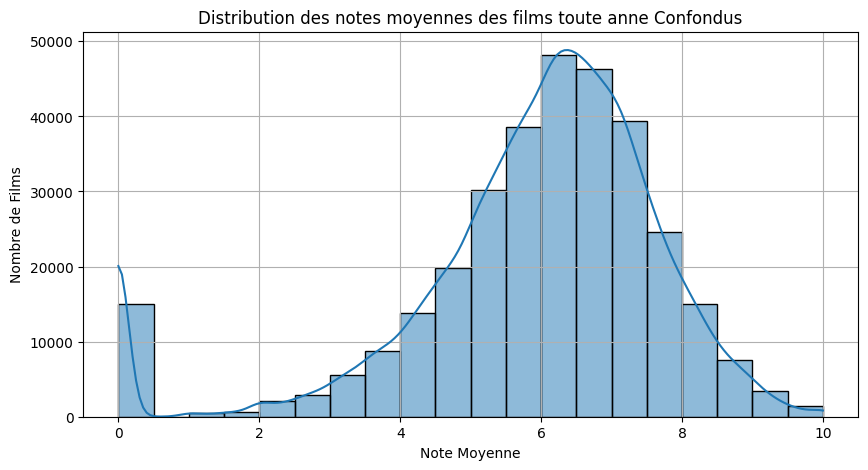

In [7]:

plt.figure(figsize=(10, 5))
sns.histplot(film_ml_df['rating_avg'], bins=20, kde=True)
plt.title('Distribution des notes moyennes des films toute anne Confondus')
plt.xlabel('Note Moyenne')
plt.ylabel('Nombre de Films')
plt.grid(True)
plt.show()

In [1]:
import pandas as pd

# Chargement du fichier CSV
file_path = 'df_final.csv'
data = pd.read_csv(file_path)

# Afficher les premières lignes et la description des données
data_head = data.head()

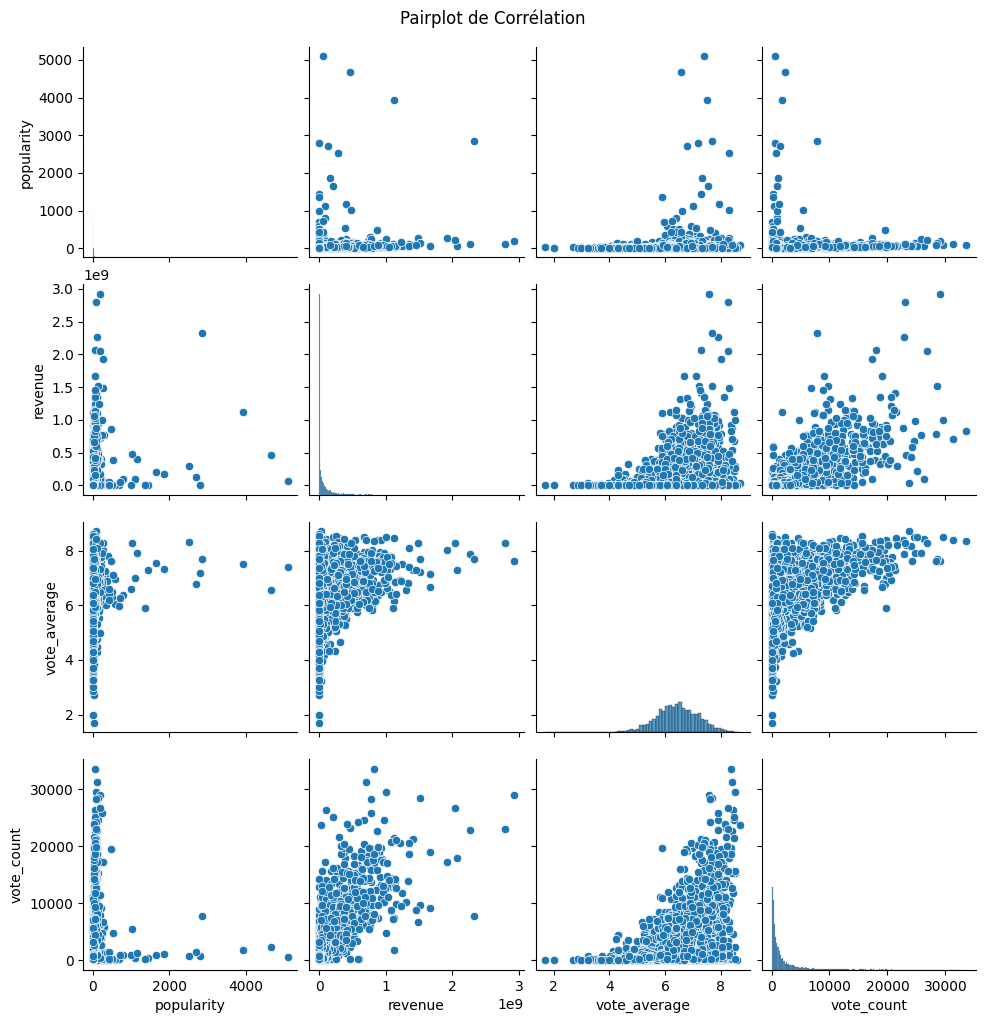

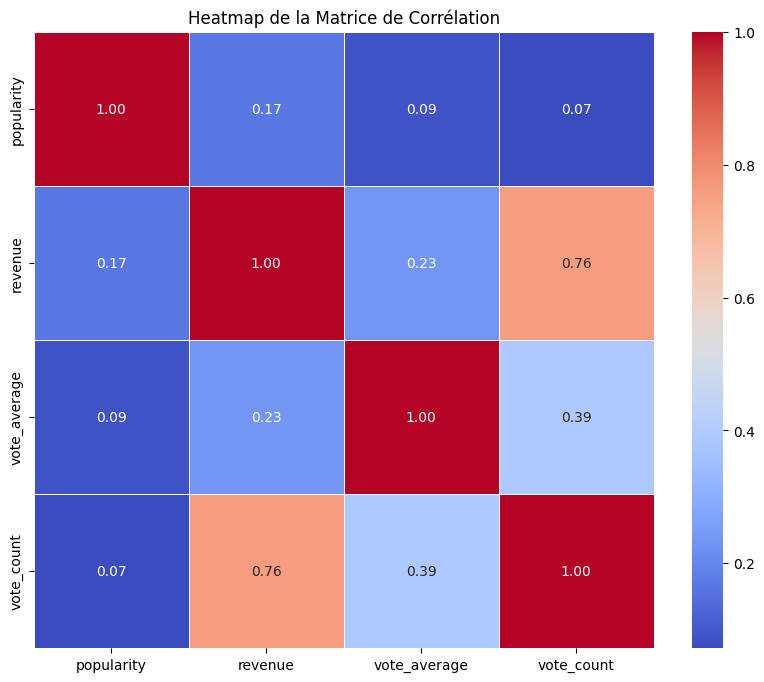

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes pour les analyses de corrélation
cols_to_analyze = ['popularity', 'revenue', 'vote_average', 'vote_count']

# Création du pairplot pour visualiser les relations entre les variables
pairplot = sns.pairplot(data[cols_to_analyze])
plt.suptitle('Pairplot de Corrélation', y=1.02)

# Création de la heatmap pour la matrice de corrélation
plt.figure(figsize=(10, 8))
correlation_matrix = data[cols_to_analyze].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap de la Matrice de Corrélation')

# Affichage des graphiques
plt.show()


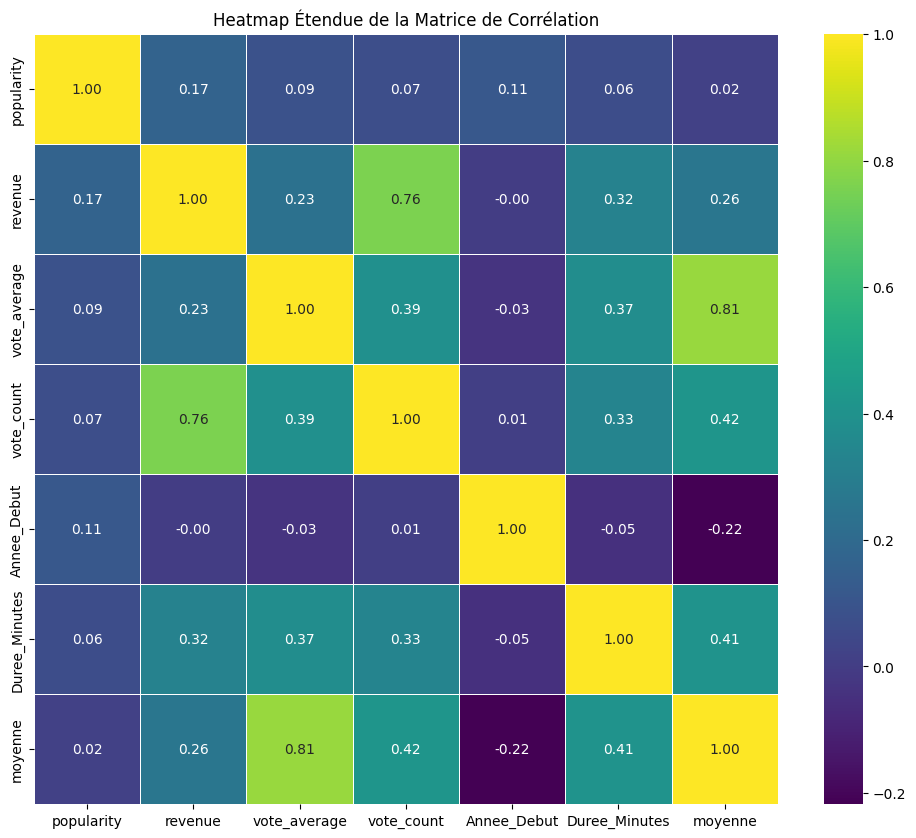

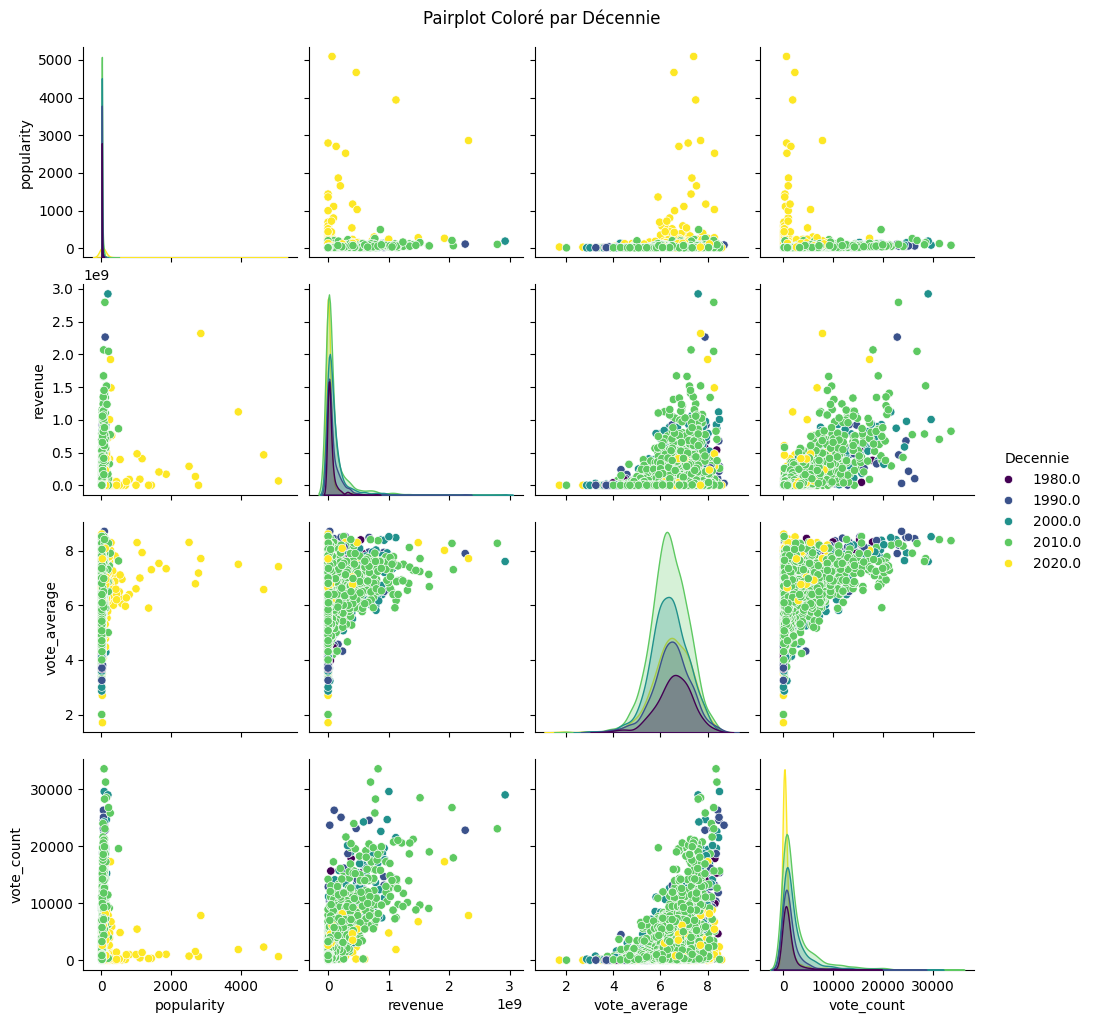

In [7]:
# Ajout de colonnes supplémentaires pour la heatmap de corrélation
cols_extended = ['popularity', 'revenue', 'vote_average', 'vote_count', 'Annee_Debut', 'Duree_Minutes', 'moyenne']

# Création d'une nouvelle heatmap avec plus de colonnes
plt.figure(figsize=(12, 10))
extended_correlation_matrix = data[cols_extended].corr()
extended_heatmap = sns.heatmap(extended_correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Heatmap Étendue de la Matrice de Corrélation')

# Pour le pairplot, colorer les points par décennie de 'Annee_Debut'
data['Decennie'] = (data['Annee_Debut'] // 10) * 10  # Création d'une colonne décennie
pairplot_colored = sns.pairplot(data[cols_to_analyze + ['Decennie']], hue='Decennie', palette='viridis')
plt.suptitle('Pairplot Coloré par Décennie', y=1.02)

# Affichage des graphiques
plt.show()


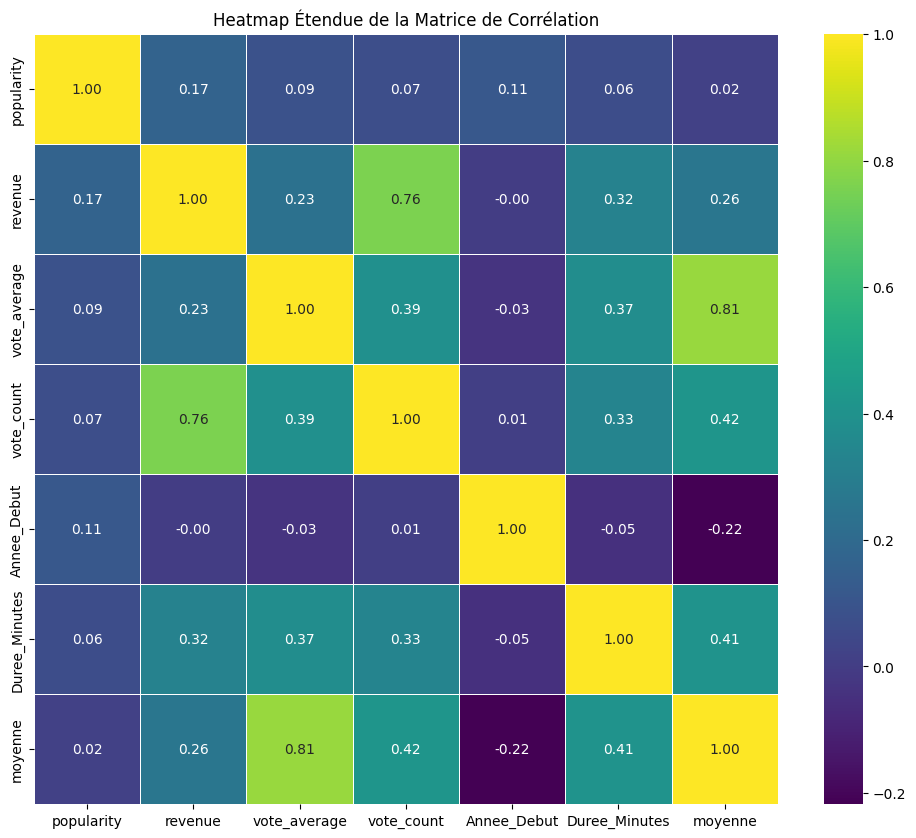

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   popularity    5475 non-null   float64
 1   revenue       5475 non-null   int64  
 2   vote_average  5475 non-null   float64
 3   vote_count    5475 non-null   int64  
 4   Decennie      5475 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 214.0 KB


In [5]:
# Affichage de la heatmap étendue seule, car elle a été générée correctement
plt.figure(figsize=(12, 10))
sns.heatmap(extended_correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Heatmap Étendue de la Matrice de Corrélation')
plt.show()

# Vérification des types de données pour les colonnes utilisées dans le pairplot
data[cols_to_analyze + ['Decennie']].info()


In [15]:
# Chargement du fichier df_final.csv
df_final = pd.read_csv('df_final1.csv')

# Tri des films par ordre décroissant de popularité
df_final_sorted = df_final.sort_values(by='popularity', ascending=False)

# Réinitialisation de l'index du DataFrame trié
df_final_sorted.reset_index(drop=True, inplace=True)

# Enregistrement du DataFrame trié en tant que df_final2.csv
df_final_sorted.to_csv('df_final2.csv', index=False)


       tconst  popularity    revenue  vote_average  vote_count  \
0  tt13375076    5089.969   65675816         7.411         627   
1  tt10954600    4665.438  464566092         6.573        2301   

                     Titre_Principal  Annee_Debut  Duree_Minutes  \
0                The Pope's Exorcist       2023.0          103.0   
1  Ant-Man and the Wasp: Quantumania       2023.0          124.0   

                    Genres  moyenne  ...   producer     writer  \
0          Horror,Thriller      6.1  ...  nm1000411  nm0678104   
1  Action,Adventure,Comedy      6.1  ...  nm0112780  nm3278218   

   primaryName_director                   knownForTitles_director  \
0          Julius Avery   tt4530422,tt2452200,tt1232785,tt2366035   
1           Peyton Reed  tt0478970,tt0204946,tt5095030,tt10954600   

   primaryName_producer                   knownForTitles_producer  \
0          Doug Belgrad  tt4495098,tt5033998,tt13375076,tt1502397   
1     Stephen Broussard   tt0458339,tt1300854,tt121

In [14]:
import pandas as pd
df_final2 = pd.read_csv('df_final2.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'df_final2.csv'